# Goingdeeper05
## Class Activation Map 만들기
### 라이브러리 가져오기

In [12]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

### 데이터불러오기

In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

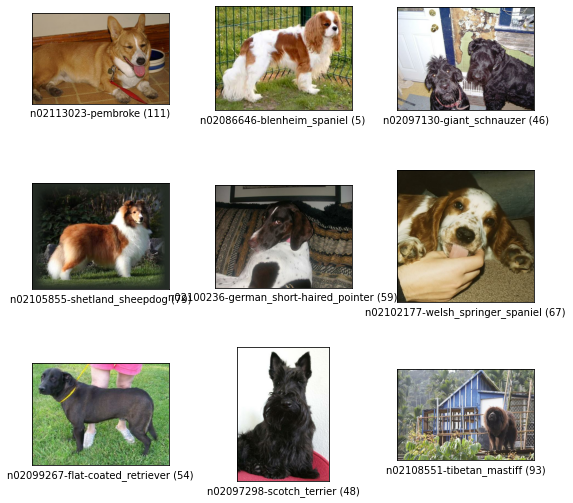

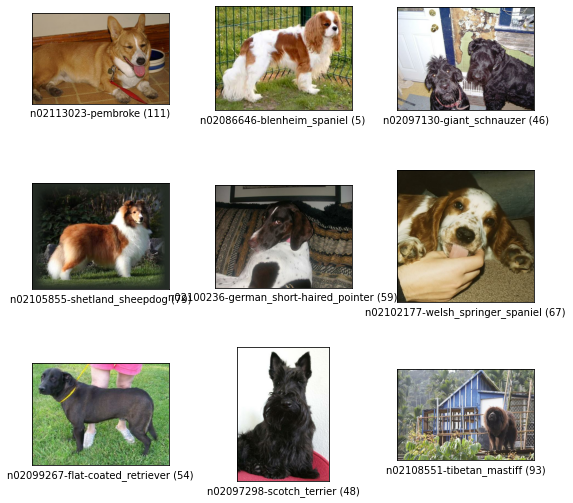

In [14]:
tfds.show_examples(ds_train, ds_info)

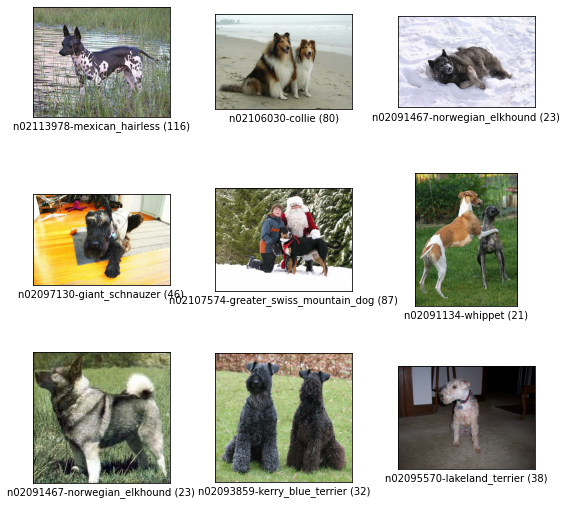

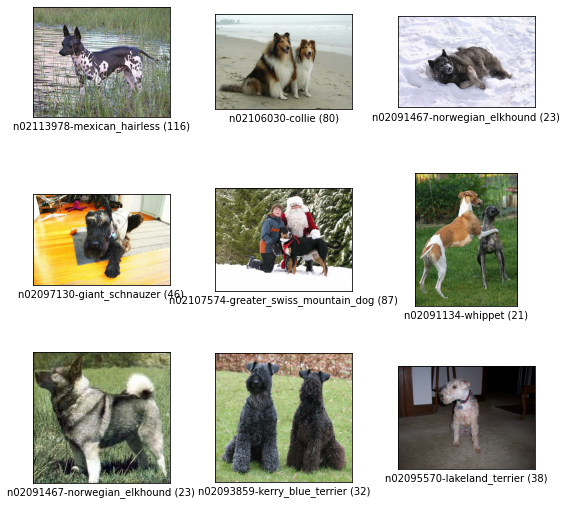

In [15]:
tfds.show_examples(ds_test, ds_info)

In [16]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [23]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False,with_aug=False,batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size=16)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [27]:
ds_train_norm = apply_normalize_on_dataset(ds_train,with_aug=False)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


### Cam 모델 만들기

In [28]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [29]:
cam_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [31]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [32]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 163s 209ms/step - loss: 2.2301 - accuracy: 0.4458 - val_loss: 2.9542 - val_accuracy: 0.2856
Epoch 2/10
750/750 [==============================] - 155s 207ms/step - loss: 0.7052 - accuracy: 0.8079 - val_loss: 1.0269 - val_accuracy: 0.6930
Epoch 3/10
750/750 [==============================] - 154s 205ms/step - loss: 0.2277 - accuracy: 0.9536 - val_loss: 1.0024 - val_accuracy: 0.7060
Epoch 4/10
750/750 [==============================] - 154s 205ms/step - loss: 0.1150 - accuracy: 0.9852 - val_loss: 0.9673 - val_accuracy: 0.7248
Epoch 5/10
750/750 [==============================] - 153s 205ms/step - loss: 0.0411 - accuracy: 0.9967 - val_loss: 0.9169 - val_accuracy: 0.7428
Epoch 6/10
750/750 [==============================] - 155s 207ms/step - loss: 0.0203 - accuracy: 0.9989 - val_loss: 0.9332 - val_accuracy: 0.7417
Epoch 7/10
750/750 [==============================] - 154s 206ms/step - loss: 0.0231 - accuracy: 0.9983 - val_loss: 0.9491 -

In [33]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### CAM 구현해보기
#### 1.아이템을 뽑아온다.
#### 2.아이템의 width과 height를 변수에 저장해준다
#### 3.아이템을 리사이즈 해준뒤 이미지텐서와 클래스에 저장해준다.
#### 4.모델의 출력을 두 갈래로 나눠준다 softmax를 쓰기전과 후로
#### 5. 그리고 마지막 가중치를 가져와 얼마나 겹치는지 확인해준다.

In [36]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]  
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [38]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

11


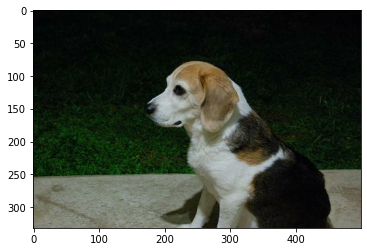

In [178]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

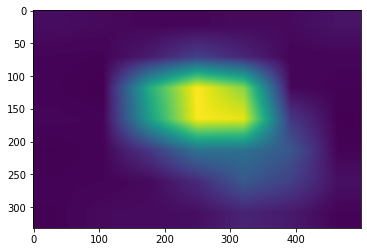

In [179]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [180]:
def visualize_cam_on_image(src1, src2, alpha=0.8):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

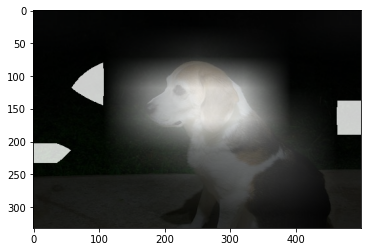

In [181]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### grad_cam함수 만들기
#### 기본적인 cam과 거의 비슷하다. 다른점이 있다면 원하는 레이어에서의 가중치 곱을 할수있다. 이 점을 생각하면서 함수를 만들어보자.

In [182]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] 
        output = conv_output[0] 
        grad_val = tape.gradient(loss, conv_output)[0] 

    weights = np.mean(grad_val, axis=(0, 1)) 
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

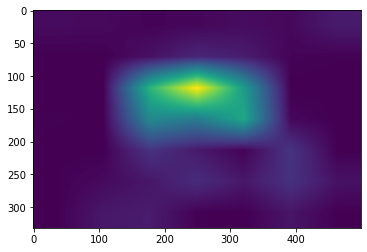

In [186]:
grad_cam_image1 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image1)
plt.show()

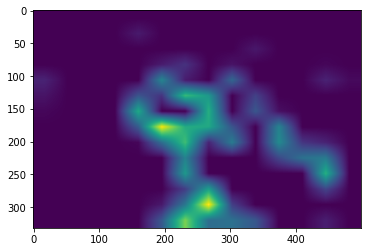

In [224]:
grad_cam_image2 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image2)
plt.show()

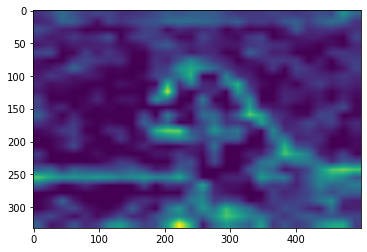

In [188]:
grad_cam_image3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image3)
plt.show()

### 바운딩박스 구하기

11


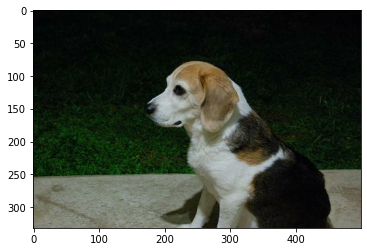

In [190]:
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [191]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [192]:
rect = get_bbox(cam_image)
rect

array([[ 59, 170],
       [216, -40],
       [516, 182],
       [359, 393]])

In [213]:
rect2 = get_bbox(grad_cam_image1)
rect2
rect3 = get_bbox(grad_cam_image2)
rect3
rect4 = get_bbox(grad_cam_image3)
rect4

array([[104, 183],
       [120, 163],
       [153, 189],
       [137, 209]])

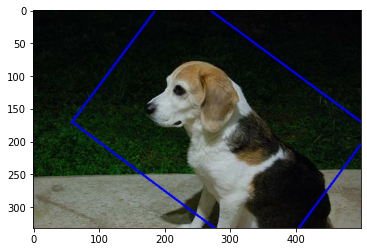

In [194]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### con5바운딩박스

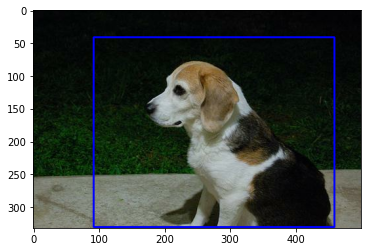

In [214]:
image2 = copy.deepcopy(item['image'])
image2 = cv2.drawContours(image2, [rect2], 0, (0,0,255), 2)
plt.imshow(image2)
plt.show()

### con3바운딩박스

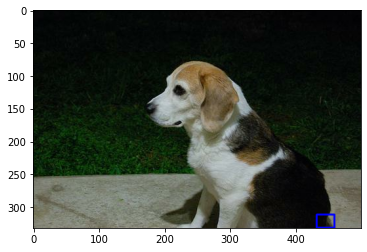

In [215]:
image3 = copy.deepcopy(item['image'])
image3 = cv2.drawContours(image3, [rect3], 0, (0,0,255), 2)
plt.imshow(image3)
plt.show()

### con4바운딩박스

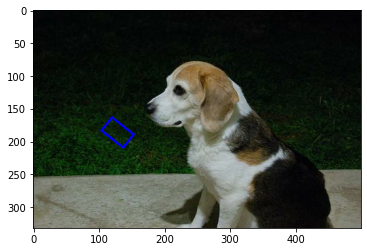

In [225]:
image4 = copy.deepcopy(item['image'])
image4 = cv2.drawContours(image4, [rect4], 0, (0,0,255), 2)
plt.imshow(image4)
plt.show()

### Gradcam은 5에서 바운딩박스를 더 잘 만들어냈다. 나머지는 4,5는 쓰레기수준이었다.

### iou구하기

In [166]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [167]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.16666666666666666, 0.184375, 1.6375, 1.6125]

In [217]:
pred_bbox2 = rect_to_minmax(rect2, item['image'])
pred_bbox2

[0.12349397590361445, 0.184, 0.9939759036144579, 0.918]

In [218]:
pred_bbox3 = rect_to_minmax(rect3, item['image'])
pred_bbox3

[0.9367469879518072, 0.864, 0.9969879518072289, 0.918]

In [219]:
pred_bbox4 = rect_to_minmax(rect4, item['image'])
pred_bbox4

[0.49096385542168675, 0.208, 0.6295180722891566, 0.306]

In [220]:
item['objects']['bbox']

array([[0.22289157, 0.326     , 0.9909639 , 0.916     ]], dtype=float32)

In [169]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

### cam iou

In [170]:
get_iou(pred_bbox, item['objects']['bbox'][0])


0.17950182411532017

### grad cam iou_con5

In [221]:
get_iou(pred_bbox2, item['objects']['bbox'][0])

0.7092483541826857

### grad cam iou_con3

In [222]:
get_iou(pred_bbox3, item['objects']['bbox'][0])

0.006215389825765511

### grad cam iou_con4

In [223]:
get_iou(pred_bbox4, item['objects']['bbox'][0])

0.0

### iou 점수도 grad cam_con5가 제일 높았다.  class activation map을 오늘 처음 이해해보고 만들어보았는데 편한 기능인것같다. 이번에도 역시 재밌는 실습이었다. 이것으로 Goingdeeper05를 마친다.